## Загрузка библиотек

In [57]:
%run -i "D:/Data_Science/Projects/PIK/import_lib.ipynb"
seed = 42

from boruta import BorutaPy
from sklearn.utils import class_weight
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import PredefinedSplit

## Чтение данных

In [58]:
df = pd.read_csv("data_prep.csv", index_col=0)

In [59]:
print(df.shape)
df.head()

(10486, 62)


,bulk_id,spalen,mean_sq,price,ipoteka,mean_fl,month,month_cnt,value,avtomoika,dep_1,dep_1_3,dep_3,input_groups,dvor_no_car,det_sad,to_cremlin,to_sadoviy,to_ttk,to_big_road,to_metro,to_park_foot,to_park,to_prom,to_conv_avtorazvyazka,kladovie,num_pomesh,kolyas,course,mashinomest,ogorozh_ter,dvor_sq,green_sq_500,zem_sq,prom_sq_500,parking_under,station_num_koltso,fok,school,poliklinnika_0,poliklinnika_500,poliklinnika_510,poliklinnika_600,object_class_0,object_class_1,object_class_2,video_0,video_1,video_2,vent_0,vent_1,vent_2,cond_0,cond_1,cond_3,spalen_0,spalen_1,spalen_2,spalen_3,spalen_4,year,quarter
6516,23,2,60.10,93238.000000,13.3,12,7,7,60.10,1,8.84,8.74,9.69,0,0,1000,25.0,23.0,19.0,1.5,5.1,0.34,0.25,0.46,7.3,1,3301,0,57.17967,2625,1,7343.0,262718.0,22.0,13442.0,0,12.0,0,2500,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,2015,3
4021,33,1,35.30,115042.000000,13.3,8,7,7,282.37,1,8.84,8.74,9.69,0,1,900,19.0,16.0,14.0,1.6,1.5,1.30,1.10,0.13,10.0,0,3685,0,57.17967,1400,1,5903.0,0.0,41.0,136344.0,0,8.0,0,3250,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,2015,3
4023,36,0,26.29,90922.210008,13.3,5,7,7,78.87,1,8.84,8.74,9.69,0,1,900,19.0,16.0,14.0,1.3,1.2,1.50,1.30,0.13,9.5,0,3685,0,57.17967,1400,1,6083.0,0.0,41.0,265718.0,0,8.0,0,3250,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,2015,3
4022,36,1,36.02,85753.568871,13.3,5,7,7,396.22,1,8.84,8.74,9.69,0,1,900,19.0,16.0,14.0,1.3,1.2,1.50,1.30,0.13,9.5,0,3685,0,57.17967,1400,1,6083.0,0.0,41.0,265718.0,0,8.0,0,3250,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,2015,3
6513,60,1,37.92,66077.983700,13.3,6,7,7,455.00,1,8.84,8.74,9.69,0,0,1000,25.0,23.0,19.0,1.9,4.7,0.50,0.30,0.30,6.4,1,3301,0,57.17967,2625,1,7968.0,111466.0,22.0,13391.0,0,12.0,0,2500,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,2015,3


## Parameters

In [60]:
# Create the model with several hyperparameters
model = lgbm.LGBMRegressor(objective='regression', boosting_type = 'gbdt', n_estimators = 1000, \
                           class_weight = None, n_jobs=-1)

# нужно ли подбирать оптимальные параметры для модели, отбирающей наиболее информативные признаки?


# rfc = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight={0:0.51, 1:20.25}, max_depth=6)
# class_weight.compute_class_weight('balanced', np.unique(y), y)

n_iter = 5
val_split = 0.2 # n_ter (5) * 0.2 = 1
metric = 'rmse'
n_early_stop = 100
cv = KFold(n_splits=n_iter, random_state=seed)

## Tree-based Feature Selection 

In [61]:
# train/test split
train = df[df.value.notnull()]
test = df[df.value.isnull()]

X_train = train.drop(["value"], axis=1)
y_train = train["value"]

X_test = test.drop(["value"], axis=1)

# данные для отбора признаков делятся на обучающую выборку и на валидационную (cv), на основе которой подбираются опт параметры

In [64]:
df.shape, X_train.shape, X_test.shape

((10486, 62), (8716, 61), (1770, 61))

### validation

In [8]:
# validation = "1" # order doesn't matter, n-fold train-test split
# validation = "2" # cv (order both matters and doesn't matter)
# validation = "3" # order matters, validation



validation = "1" 



if validation == "1":

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X_train.shape[1])

    for i in range(n_iter):

        # Split into training and validation set
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = val_split, \
                                                                            random_state = i)

        # Train using early stopping
        model.fit(X_tr, y_tr, early_stopping_rounds = n_early_stop, eval_set = [(X_val, y_val)], 
                  eval_metric = metric, verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_

    # Make sure to average feature importances! 
    feature_importances = feature_importances / n_iter
    feature_importances = pd.DataFrame(index = list(X_train.columns), data = {'importance': feature_importances,}).sort_values('importance', ascending = False)
    feature_importances.head()
    
    
    
elif validation == "2":
        
    feature_importances = np.zeros(X_train.shape[1])
    
    split = cv

    for tr, val in split.split(X_train):

        # Split into training and validation set
        X_tr, X_val, = X_train.iloc[tr,:], X_train.iloc[val, :]
        y_tr, y_val, = y_train[tr], y_train[val]
        
        # Train using early stopping
        model.fit(X_tr, y_tr, eval_set = [(X_val, y_val)], early_stopping_rounds = n_early_stop,
                  eval_metric = metric, verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_
        

    # Make sure to average feature importances! 
    feature_importances = feature_importances / n_iter
    feature_importances = pd.DataFrame(index = list(X_train.columns), data = {'importance': feature_importances,}).sort_values('importance', ascending = False)
    feature_importances.head()    
    
    
    

else:
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(X_train.shape[1])


    # Split into training and validation set
    
    n_sample = X_train.shape[0]
    n_train = int((1-val_split) * n_sample)
    n_val = n_sample - n_train

    X_tr, X_val = X_train.iloc[:n_train], X_train.iloc[n_train:]
    y_tr, y_val = y_train.iloc[:n_train], y_train.iloc[n_train:]


    # Train using early stopping
    model.fit(X_tr, y_tr, early_stopping_rounds = n_early_stop, eval_set = [(X_val, y_val)], 
              eval_metric = metric, verbose = 200)

    # Record the feature importances
    feature_importances += model.feature_importances_

    # Make sure to average feature importances! 
    feature_importances = feature_importances / n_iter
    feature_importances = pd.DataFrame(index = list(X_train.columns), data = {'importance': feature_importances,}).sort_values('importance', ascending = False)
    feature_importances.head()
    

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 237.807
[400]	valid_0's rmse: 235.609
Early stopping, best iteration is:
[437]	valid_0's rmse: 235.134
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 228.059
[400]	valid_0's rmse: 223.459
[600]	valid_0's rmse: 221.726
[800]	valid_0's rmse: 220.749
Early stopping, best iteration is:
[732]	valid_0's rmse: 220.293
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 241.357
[400]	valid_0's rmse: 239.01
[600]	valid_0's rmse: 238.317
Early stopping, best iteration is:
[573]	valid_0's rmse: 238.185
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 220.016
[400]	valid_0's rmse: 217.745
Early stopping, best iteration is:
[361]	valid_0's rmse: 217.558
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 227.014
[400]	valid_0's rmse: 220.047
[600]	valid_0's rmse: 218.906
[800]	

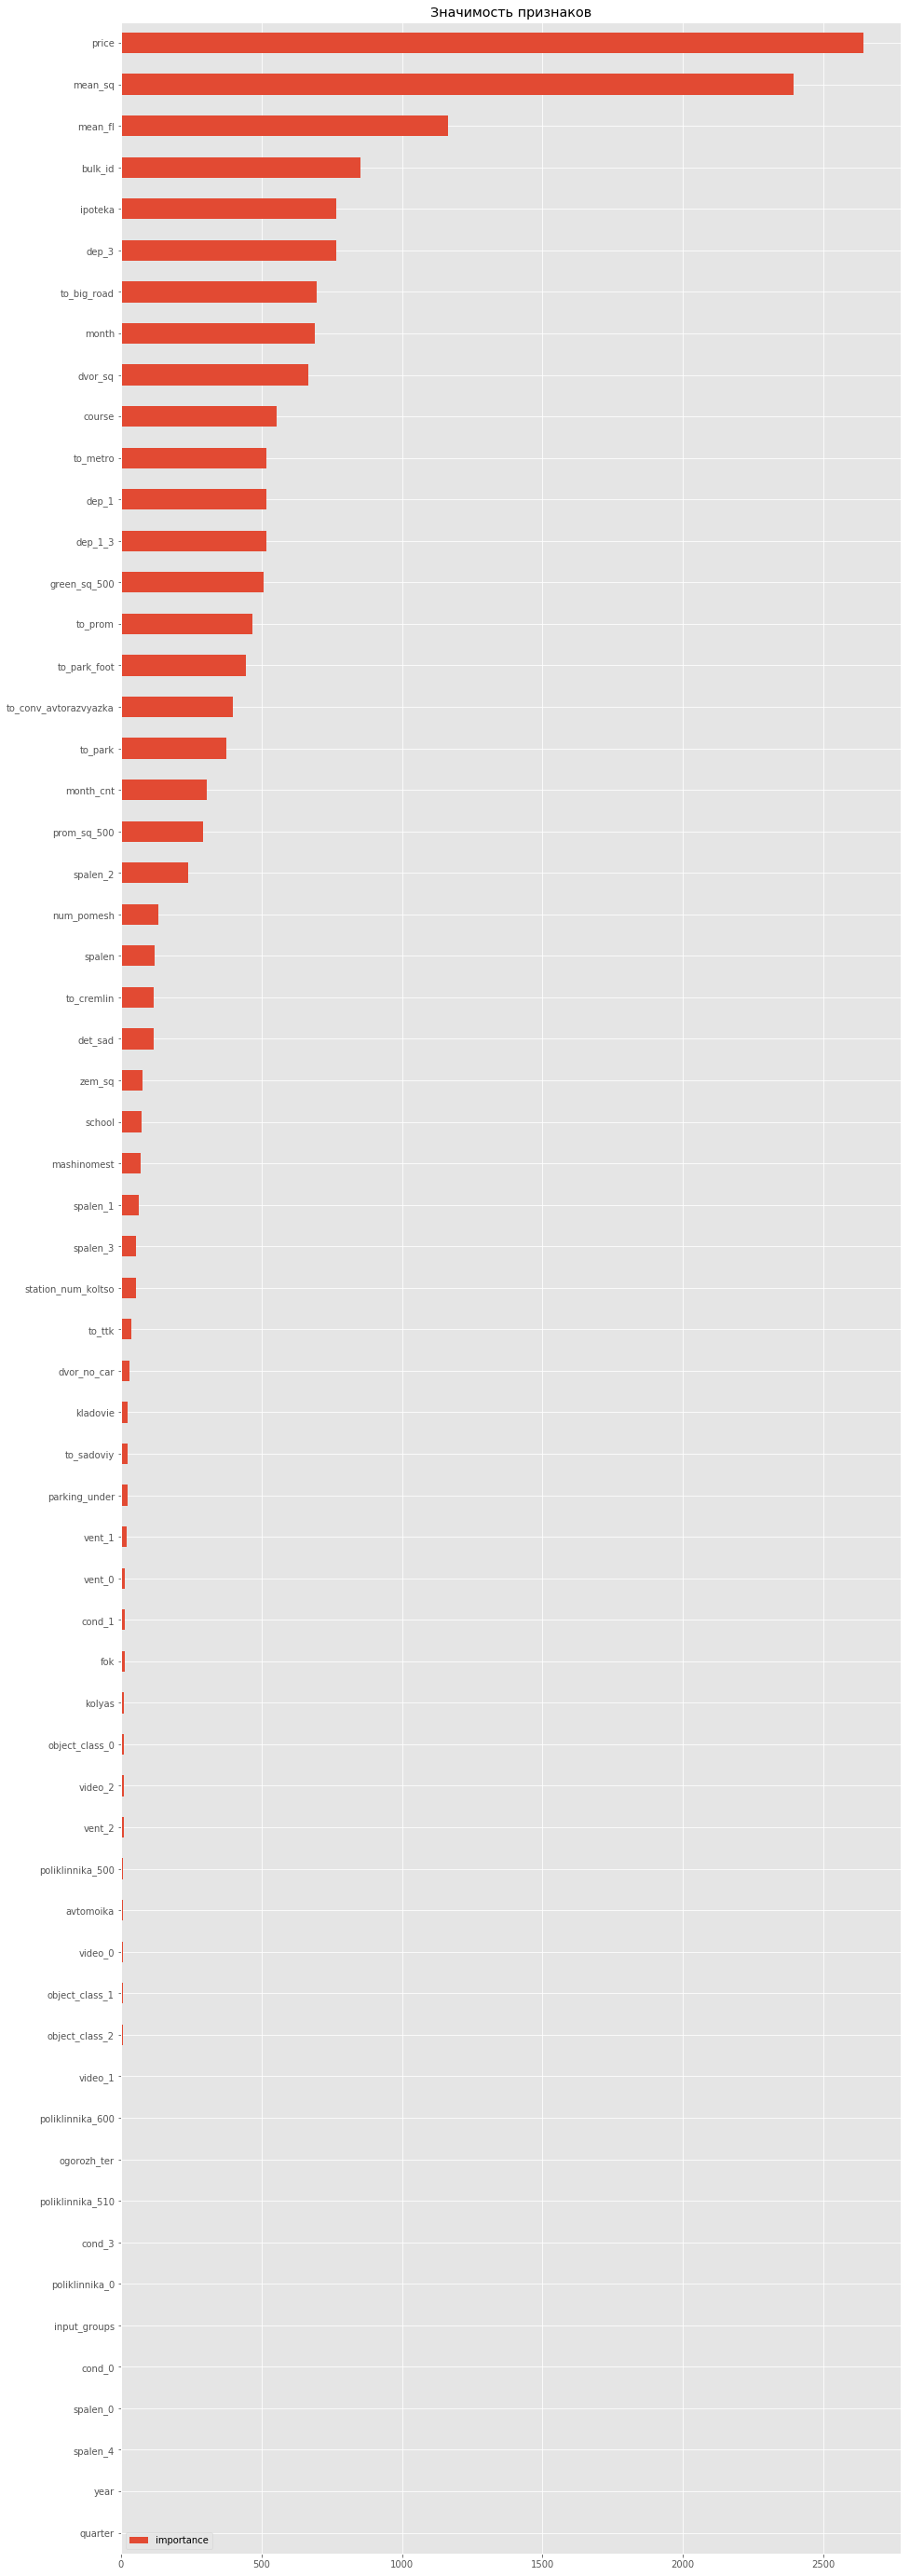

In [9]:
# feature_importances
feature_importances.plot(kind='barh', figsize=(15, 50)).invert_yaxis()
plt.title('Значимость признаков')
plt.show()

### cumulative feature importance

In [10]:
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['importance_normalized'])

In [11]:
cum_imp = list(feature_importances.cumulative_importance)
feature_list = list(feature_importances.index)
x_values = list(range(feature_importances.shape[0]))

23 features required for 0.95 of cumulative importance


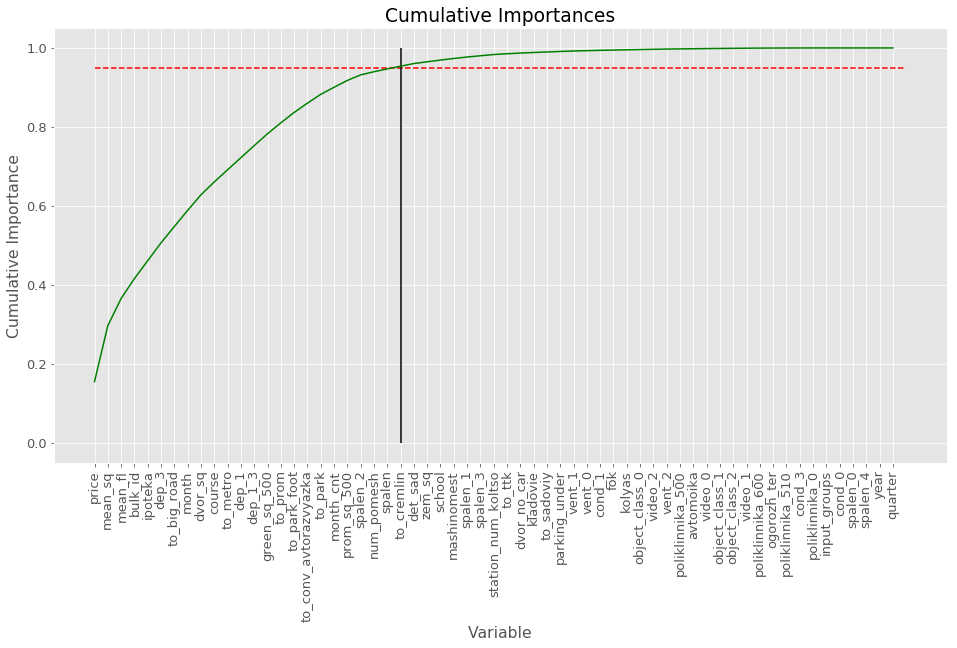

In [12]:
fi_threshold = 0.95

lgb_features = feature_importances[feature_importances.cumulative_importance < fi_threshold].index
print('%d features required for %0.2f of cumulative importance' % (len(lgb_features), fi_threshold))

plt.figure(figsize = (16, 8))
plt.rcParams['font.size'] = 13
plt.plot(x_values, cum_imp, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = fi_threshold, xmin=0, xmax=len(feature_list), color = 'r', linestyles = 'dashed')

plt.vlines(x = len(lgb_features), ymin=0, ymax=1, color = 'black')

# Format x ticks and labels
plt.xticks(x_values, feature_list, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [13]:
lgb_features

Index(['price', 'mean_sq', 'mean_fl', 'bulk_id', 'ipoteka', 'dep_3',
       'to_big_road', 'month', 'dvor_sq', 'course', 'to_metro', 'dep_1',
       'dep_1_3', 'green_sq_500', 'to_prom', 'to_park_foot',
       'to_conv_avtorazvyazka', 'to_park', 'month_cnt', 'prom_sq_500',
       'spalen_2', 'num_pomesh', 'spalen'],
      dtype='object')

In [14]:
feature_importances.head()

,importance,importance_normalized,cumulative_importance
price,2642.8,0.156138,0.156138
mean_sq,2395.0,0.141498,0.297637
mean_fl,1163.2,0.068723,0.366359
bulk_id,851.8,0.050325,0.416684
ipoteka,767.2,0.045327,0.462011


In [15]:
feature_importances.tail()

,importance,importance_normalized,cumulative_importance
cond_0,0.0,0.0,1.0
spalen_0,0.0,0.0,1.0
spalen_4,0.0,0.0,1.0
year,0.0,0.0,1.0
quarter,0.0,0.0,1.0


In [16]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances.importance==0].index)
pp.pprint(zero_features)
print("Число признаков с нулевой значимостью: ", len(zero_features))

['cond_0', 'spalen_0', 'spalen_4', 'year', 'quarter']
Число признаков с нулевой значимостью:  5


In [17]:
#drop featurees with 0 importance

# X_train  =  X_train.drop(zero_features, axis=1)
# X_test = X_test.drop(columns = zero_features, axis=1)

In [18]:
# select features giving x% cum importance

# X_train  =  X_train[lgb_features]
# X_test  =  X_test[lgb_features]

## Boruta Feature Selection

In [19]:
X_train = train.drop(["value"], axis=1).values
y_train = train["value"].values

In [20]:
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_depth=7, random_state=seed)
# rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight={0:0.51, 1:20.25}, max_depth=7)

boruta_selector = BorutaPy(rfr, n_estimators="auto", verbose=2, random_state=seed)

In [21]:
%%time
boruta_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	34
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	34
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	34
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	34
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	34
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	34
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	34
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	18
Rejected: 	34
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	14
Reject

BorutaPy(alpha=0.05,
     estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=-1,
           oob_score=False,
           random_state=<mtrand.RandomState object at 0x0000026EB2105B40>,
           verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x0000026EB2105B40>,
     two_step=True, verbose=2)

In [22]:
# number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)


 Number of selected features:
16


In [23]:
feature_df = pd.DataFrame(train.drop(["value"], axis=1).columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
boruta_features = pd.DataFrame(feature_df["features"].head(boruta_selector.n_features_)).features
pd.DataFrame(boruta_features)
# feature_df.to_csv('boruta-feature-ranking.csv', index=False)


 Top 16 features:


,features
0,dvor_sq
1,to_big_road
2,to_park
3,det_sad
4,num_pomesh
5,to_metro
6,green_sq_500
7,mashinomest
8,station_num_koltso
9,mean_fl


In [24]:
print ('\n Tree-based and Boruta method have %d features in common:' % \
                       len(   set(lgb_features) & set(boruta_features)  ))

pp.pprint (  set(lgb_features) & set(boruta_features)  )      


 Tree-based and Boruta method have 13 features in common:
{   'dvor_sq',
    'green_sq_500',
    'ipoteka',
    'mean_fl',
    'mean_sq',
    'month_cnt',
    'num_pomesh',
    'price',
    'spalen_2',
    'to_big_road',
    'to_metro',
    'to_park',
    'to_park_foot'}


## RFE selection

In [25]:
%%time

does_the_order_matter = "no"


if does_the_order_matter == "no":
        
    rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_squared_error')
    rfecv.fit(X_train, y_train)

else:
    
    # Split into training and validation set
    
    n_sample = X_train.shape[0]
    n_train = int((1-val_split) * n_sample)
    n_val = n_sample - n_train

    X_tr, X_val = X_train.iloc[:n_train], X_train.iloc[n_train:]
    y_tr, y_val = y_train.iloc[:n_train], y_train.iloc[n_train:]

    validation_set_indexes = [-1]*len(X_tr) + [0]*len(X_val)
    ps = PredefinedSplit(test_fold=validation_set_indexes)

    rfecv = RFECV(estimator=model, step=1, cv=ps, scoring='neg_mean_squared_error')
    rfecv.fit(X_train, y_train)

Wall time: 9min 53s


Optimal number of features : 22


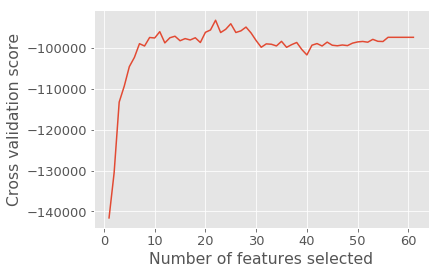

In [26]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [97]:
selector = RFE(model, n_features_to_select=rfecv.n_features_, step=1, verbose=1)
selector.fit(X_train, y_train)

Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 fe

RFE(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
  n_features_to_select=22, step=1, verbose=10)

### !

In [69]:
X_train = train.drop(["value"], axis=1)
y_train = train["value"]

In [70]:
rfe_features = list(X_train.iloc[:,selector.support_].columns)
print(X_train.iloc[:,selector.support_].shape)
X_train.iloc[:,selector.support_].head()

(8716, 22)


,bulk_id,mean_sq,price,ipoteka,mean_fl,month,month_cnt,dep_1,dep_1_3,dep_3,det_sad,to_big_road,to_metro,to_park_foot,to_park,to_prom,to_conv_avtorazvyazka,course,dvor_sq,green_sq_500,prom_sq_500,spalen_2
6516,23,60.10,93238.000000,13.3,12,7,7,8.84,8.74,9.69,1000,1.5,5.1,0.34,0.25,0.46,7.3,57.17967,7343.0,262718.0,13442.0,1
4021,33,35.30,115042.000000,13.3,8,7,7,8.84,8.74,9.69,900,1.6,1.5,1.30,1.10,0.13,10.0,57.17967,5903.0,0.0,136344.0,0
4023,36,26.29,90922.210008,13.3,5,7,7,8.84,8.74,9.69,900,1.3,1.2,1.50,1.30,0.13,9.5,57.17967,6083.0,0.0,265718.0,0
4022,36,36.02,85753.568871,13.3,5,7,7,8.84,8.74,9.69,900,1.3,1.2,1.50,1.30,0.13,9.5,57.17967,6083.0,0.0,265718.0,0
6513,60,37.92,66077.983700,13.3,6,7,7,8.84,8.74,9.69,1000,1.9,4.7,0.50,0.30,0.30,6.4,57.17967,7968.0,111466.0,13391.0,0


In [71]:
print ('\n Tree-based and Boruta method have %d features in common:' % \
                       len(   set(lgb_features) & set(boruta_features)  & set(rfe_features)   ))

pp.pprint (  set(lgb_features) & set(boruta_features)  & set(rfe_features)   )                 


 Tree-based and Boruta method have 12 features in common:
{   'dvor_sq',
    'green_sq_500',
    'ipoteka',
    'mean_fl',
    'mean_sq',
    'month_cnt',
    'price',
    'spalen_2',
    'to_big_road',
    'to_metro',
    'to_park',
    'to_park_foot'}


## Select KBest

In [72]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [86]:
print(rfecv.n_features_)
kbest = SelectKBest(score_func=chi2, k=rfecv.n_features_)
kbest.fit(X_train, y_train.astype('int'))
scores = -np.log10(kbest.pvalues_)

22


In [95]:
fi_kbest = pd.DataFrame(index = list(X_train.columns), \
                        data = {'importance': scores,}).sort_values('importance', ascending = False)
fi_kbest.head()

,importance
bulk_id,inf
det_sad,inf
school,inf
prom_sq_500,inf
zem_sq,inf


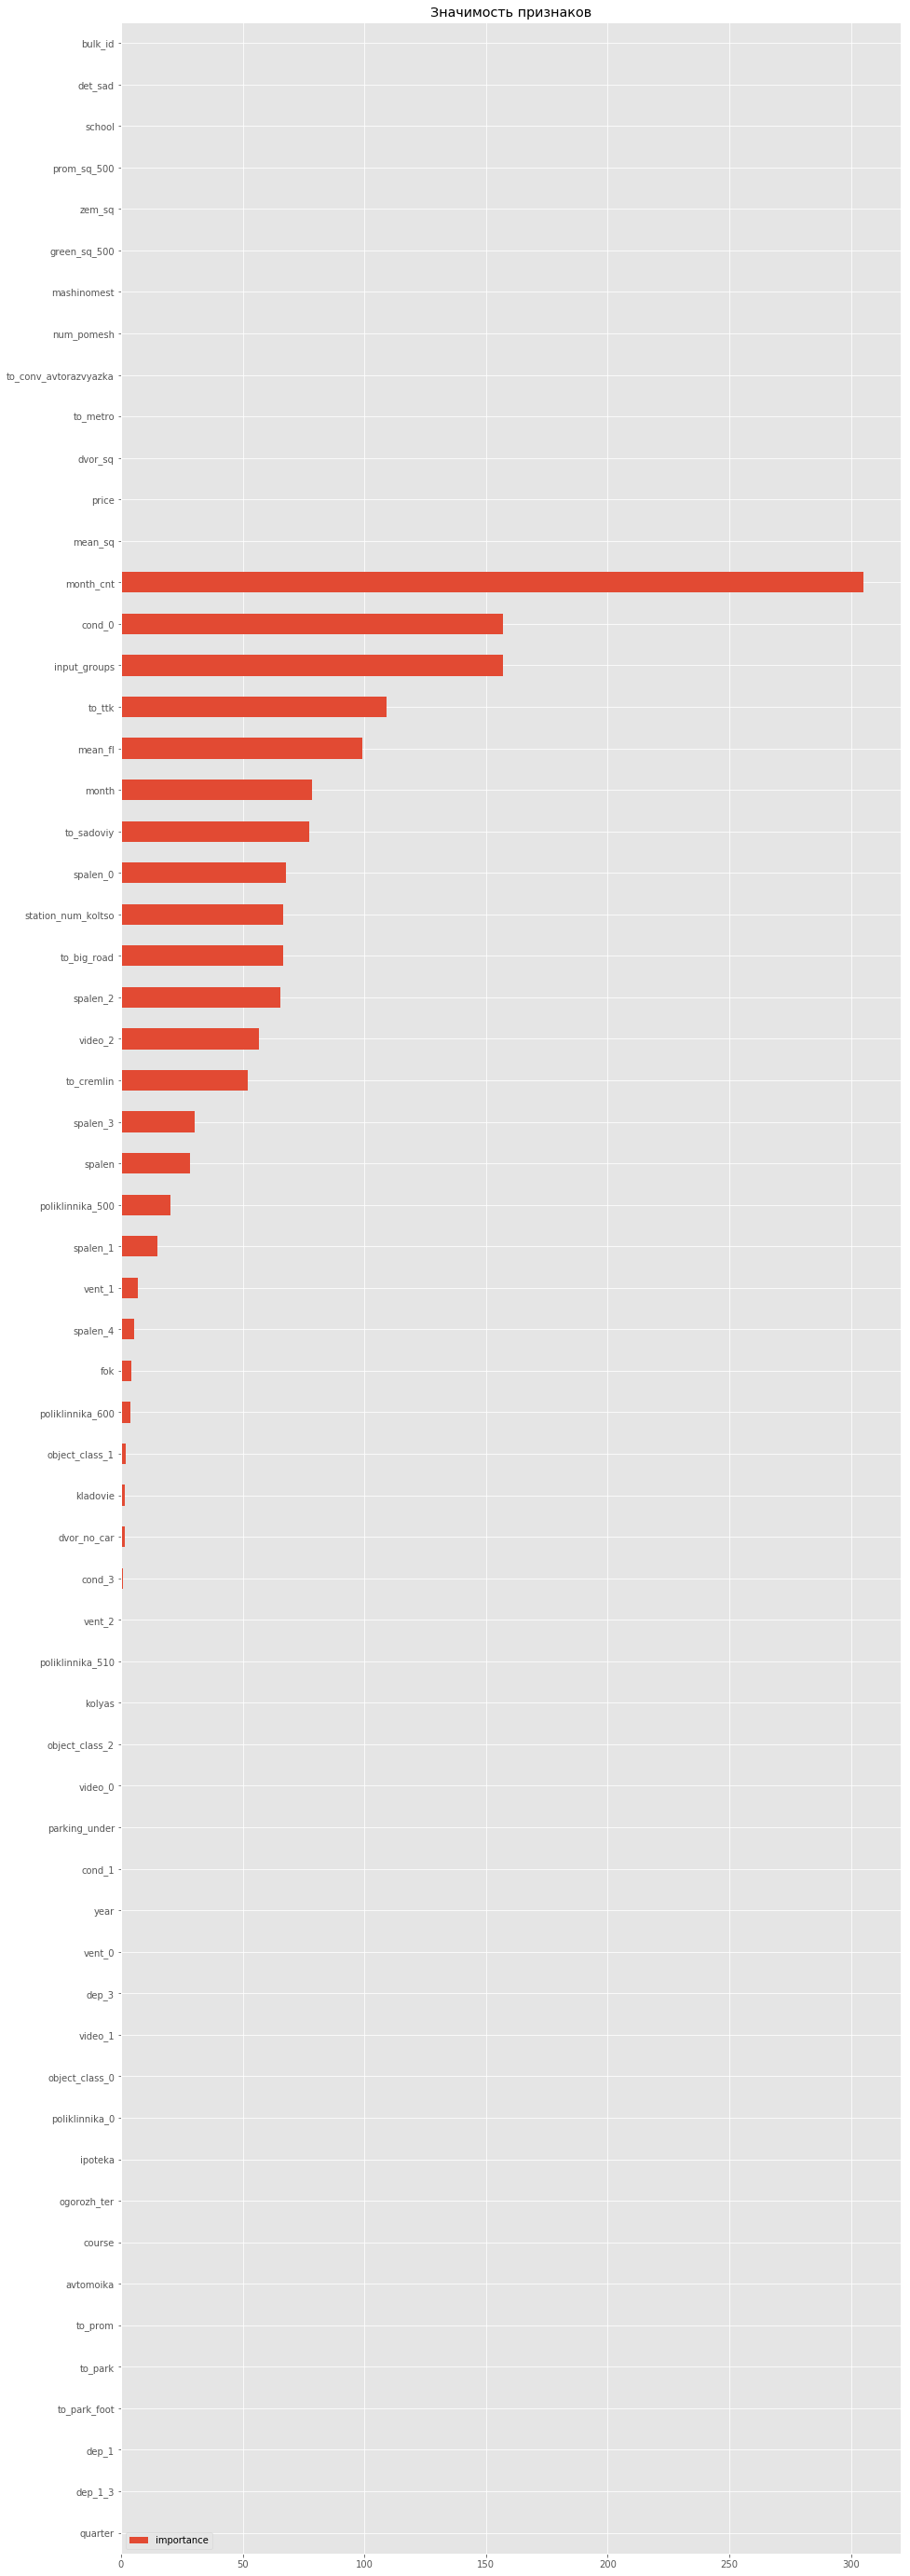

In [96]:
# feature_importances
fi_kbest.plot(kind='barh', figsize=(15, 50)).invert_yaxis()
plt.title('Значимость признаков')
plt.show()

## Lasso Regression

In [247]:
# https://stackoverflow.com/questions/34238590/finding-optimal-feature-using-lasso-regression-in-binary-classification

In [248]:
round(1.200,2)

1.2

In [255]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import SGDRegressor

tuned_parameters = {'alpha': np.arange(0, 2, 0.2)}
lasso_gs = GridSearchCV(SGDRegressor(loss='squared_loss', penalty='elasticnet',l1_ratio=0.15, n_iter=5, shuffle=False, \
                    verbose=False, average=False), 
                    tuned_parameters, cv=cv, scoring='neg_mean_squared_error')


lasso_gs.fit(X_train, y_train)
lasso = Lasso(alpha=lasso_gs.best_params_.get('alpha')).fit(X_train, y_train)

print("alpha: ", round(lasso_gs.best_params_.get('alpha'),2))

lasso_df = pd.DataFrame({"coef": lasso.coef_}, index = X_train.columns)
print("quantity of features to select: ", lasso_df[lasso_df.coef!=0.0].shape[0])
lasso_df[lasso_df.coef!=0.0].sort_values(by="coef").head()

alpha:  1.2
quantity of features to select:  41


,coef
to_prom,-108.795588
dvor_no_car,-97.966255
spalen_0,-89.828899
vent_2,-74.349041
to_cremlin,-70.358298


In [246]:
lasso = Lasso(alpha=1.5).fit(X_train, y_train)
lasso_df = pd.DataFrame({"coef": lasso.coef_}, index = X_train.columns)
print("quantity of features to select: ", lasso_df[lasso_df.coef!=0.0].shape[0])
lasso_df[lasso_df.coef!=0.0].sort_values(by="coef").head()

quantity of features to select:  41


,coef
dvor_no_car,-100.237054
spalen_0,-89.565590
to_prom,-89.091941
to_cremlin,-56.946611
vent_2,-51.601896


In [258]:
sfm = SelectFromModel(lasso, threshold=0)
sfm.fit(X_train, y_train)
n_features = sfm.transform(X_train).shape[1]
print(n_features)
while n_features != rfecv.n_features_:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X_train)
    n_features = X_transform.shape[1]
print("--")
print(n_features)

61
--
22


In [190]:
lasso_idx = sfm.get_support()
lasso_features = X_train.columns[lasso_idx]

In [191]:
# init_feat = list(X_train.columns) 
# var_sel_feat = list(feature_name)
# [item for item in init_feat if item not in var_sel_feat]

In [192]:
print ('\n Tree-based and Boruta method have %d features in common:' % \
                       len(   set(lgb_features) & set(lasso_features)  ))

pp.pprint (  set(lgb_features) & set(lasso_features)  )   


 Tree-based and Boruta method have 5 features in common:
{'to_metro', 'to_conv_avtorazvyazka', 'spalen_2', 'to_cremlin', 'to_prom'}
